# Project: Progress Pics & Python

##### Goal: Map upvotes/downvotes against age and gender of posters in the  r/progresspics subreddit

<i>Background: Reddit is divided into "subreddits" which are smaller communities based around a common interest. The r/progresspics subreddit is a community that is meant to celebrate changes in physical appearance: weight loss, weight gain, body recomposition, etc. This project's aim is to see if there's a greater likelihood of women or men getting upvoted in the subreddit.</i>

In [1]:
import pandas as pd
import praw
import re
import substring
from functools import reduce
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr

<i>Step 1) Authorize my username to be able to use the Reddit API</i>

- This section authorizes me to use the Reddit API
- I used this page to learn how to get myself authorized with OAuth: https://github.com/reddit-archive/reddit/wiki/OAuth2-Quick-Start-Example
- I used this website to learn how to use praw (the python wrapper for the Reddit API): https://praw.readthedocs.io/en/v7.1.0/getting_started/quick_start.html

In [2]:
my_id = 'm-q759Ty4ZDByA'
my_secret = 'wjpjnJz7YWQJ8bC6Vxgtc0AzABQ'
my_agent = 'chrome:mac 10.14.6:x64:python class (by /u/theouts1der)'

r = praw.Reddit(client_id=my_id,
                     client_secret=my_secret,
                     user_agent=my_agent)

print(r.read_only)


True


In [3]:
# This is me testing out how to pull the titles
for submission in r.subreddit("progresspics").top(limit=10):
    #print(submission.title)
    #print(submission.ups)
    print(submission.num_comments)

382
738
712
270
359
263
456
279
539
346


<i> Step 2) Create a dataframe that includes the top 100,000 submissions in the r/progresspics subreddit</i>

- Desired Columns: ['Raw_Text','Gender','Age','Height','Weight_Before','Weight_After']

In [174]:
number_of_entries =1000000

all_titles=[]
for submission in r.subreddit("progresspics").top(limit=number_of_entries):
    all_titles.append(submission.title)
    
all_upvotes=[]
for submission in r.subreddit("progresspics").top(limit=number_of_entries):
    all_upvotes.append(submission.ups)
    
num_comments=[]
for submission in r.subreddit("progresspics").top(limit=number_of_entries):
    num_comments.append(submission.num_comments)
    

In [175]:
#print(num_comments)

In [176]:
df_titles = pd.DataFrame([sub.split("',") for sub in all_titles])
df_upvotes = pd.DataFrame(all_upvotes)
df_num_comments = pd.DataFrame(num_comments)

df_titles = df_titles.rename(columns={0: "Raw_Text"})
df_upvotes = df_upvotes.rename(columns={0: "Upvotes"})
df_num_comments = df_num_comments.rename(columns={0: "Number_of_comments"})

In [177]:
df_titles.head()

,Raw_Text
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ..."
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun..."
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m..."


In [179]:
df_titles.to_csv(r'test2_dataframe.csv', index = False)

In [102]:
df_upvotes.head()

,Upvotes
0,19669
1,19171
2,17064
3,16781
4,16745


In [103]:
df_num_comments.head()

,Number_of_comments
0,382
1,738
2,712
3,270
4,359


In [104]:
#source = https://thispointer.com/pandas-how-to-merge-dataframes-by-index-using-dataframe-merge-part-3/
df = df_titles.merge(df_upvotes, left_index=True, right_index=True)

In [105]:
df.head()

,Raw_Text,Upvotes
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ...",19669
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745


In [106]:
df = df.merge(df_num_comments, left_index=True, right_index=True)

In [107]:
df.head()

,Raw_Text,Upvotes,Number_of_comments
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ...",19669,382
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359


In [108]:
df.shape

(997, 3)

In [15]:
#This is me experimenting how to pull out gender
# string = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
# print(string.rsplit('/', -1)[0])

In [ ]:
# df['Gender'] = df[(row.rsplit('/', -1)[0]) for row in df['Raw_text']] --> doesn't work
# df['Gender'] = df['Raw_Text'].apply(lambda s: s.rsplit('/', -1)[0])

In [ ]:
#df.head()

In [ ]:
#The methods above didn't take into accout nonstandardized genders, so I made a function (seen below) instead

In [109]:
#http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/

string = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
testing = string.find('F')
print(testing)
print("---------")
def gender_func(sentence):
    if (sentence.find('F')) <5 and (sentence.find('F') > -1):
        return("F")
    elif (sentence.find('f')) <5 and (sentence.find('f') > -1):
        return("F")
    elif (sentence.find('M')) <5 and (sentence.find('M') > -1):
        return("M")
    elif (sentence.find('m')) <5 and (sentence.find('m') > -1):
        return("M")
    else:
        return("PASS")
gender_func(" M/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!")

0
---------


'M'

In [110]:
df['Gender'] = df['Raw_Text'].apply(gender_func)

In [111]:
df.head(20)

,Raw_Text,Upvotes,Number_of_comments,Gender
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ...",19669,382,M
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M
7,"F/24/5”8 [304>145=159lbs] Hey Look Ma, I Made It.",15369,279,F
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M


In [112]:
#This is me experimenting how to pull out age
# string = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
# new_string = string[:4][-2:]
# print(new_string)

In [113]:
#This is me experimenting how to pull out age, part 2
string2 = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
start = string2.find('/')+1
# end = string2.find('/')
print(start)
# print(end)

age=substring.substringByInd(string,startInd=(string.find('/')+1),endInd=(string.find('/')+2))
print(age)

2
31


In [114]:
df['Age'] = df['Raw_Text'].apply(lambda string: substring.substringByInd(string,startInd=(string.find('/')+1),endInd=(string.find('/')+2)))

In [115]:
df.head(20)

,Raw_Text,Upvotes,Number_of_comments,Gender,Age
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ...",19669,382,M,07
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38
7,"F/24/5”8 [304>145=159lbs] Hey Look Ma, I Made It.",15369,279,F,24
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27


In [116]:
df["Age"] = pd.to_numeric(df["Age"],errors='coerce',downcast="integer")

In [117]:
df.head(20)

,Raw_Text,Upvotes,Number_of_comments,Gender,Age
0,"M/07/1'3"" [23lbs > 13lbs = 10lbs] Still a bit ...",19669,382,M,7.0
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38.0
7,"F/24/5”8 [304>145=159lbs] Hey Look Ma, I Made It.",15369,279,F,24.0
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49.0
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27.0


In [118]:
df = df[df['Age'] > 18]

In [119]:
df.head(20)

,Raw_Text,Upvotes,Number_of_comments,Gender,Age
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38.0
7,"F/24/5”8 [304>145=159lbs] Hey Look Ma, I Made It.",15369,279,F,24.0
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49.0
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27.0
10,M/25/6’0”[285>175=110 lbs] I used to get calle...,14660,404,M,25.0


In [120]:
#https://stackoverflow.com/questions/51731946/python-regex-how-to-extract-human-height-us-from-string/51732174
#https://docs.python.org/3/library/re.html#re-objects
#https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/#:~:text=re.-,findall(),returned%20in%20the%20order%20found.
# https://stackoverflow.com/questions/4945548/remove-the-first-character-of-a-string
#https://stackoverflow.com/questions/13964986/regex-and-the-or-operator-without-grouping-in-python
#https://regex101.com/ !!!
#https://www.youtube.com/watch?v=7DG3kCDx53c


#This is me experimenting how to pull out height
# string3 = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
# new_string = string[5:10]
# print(new_string)



# pattern = re.compile("d")
# >>> pattern.search("dog")     # Match at index 0
# <re.Match object; span=(0, 1), match='d'>
# >>> pattern.search("dog", 1)  # No match; search doesn't include the "d"





string3="M/29/7'11 [605 pounds > 375 pounds = 230"
string4="M/31/6’8” [764lbs = 299lbs = 465lbs]"

# regex = '\d+'             
# match = re.findall(regex, string)  
# print(match)  

def height_func1(sentence):
    if (sentence.find("cm")) <10 and (sentence.find("cm") > 2):
        return("0")
    elif (sentence.find("'")) <10 or (sentence.find("’")) <10:
        try:
            pattern = re.compile('\d{1}(?:\'|\’)\d+')
            match = re.findall(pattern,sentence)
            return(match[0][0])
        except:
            return("0")
    else:
        return("0")
    
def height_func2(sentence):
    if (sentence.find("cm")) <10 and (sentence.find("cm") > 2):
        pattern1 = re.compile('(\\d+)cm')
        match1 = re.findall(pattern1,sentence)
        return(match1[0])
    elif (sentence.find("'")) <10 or (sentence.find("’")) <10:
        try:
            pattern = re.compile('(?:\'|\’)\d+')
            match = re.findall(pattern,sentence)
            return(match[0][1:])
        except:
            return("0")
    else:
        return("0")

In [121]:
string3="M/29/7'11 [605 pounds > 375 pounds = 230"
string4="M/31/6’8” [764lbs = 299lbs = 465lbs]"

pattern = re.compile('(?:\'|\’)\d+')
match = re.findall(pattern,string3)
print(match[0][1:])

11


In [122]:
height_func1(string4)

'6'

In [123]:
height_func2(string4)

'8'

In [124]:
#in which we use regex to find the height in cm
# string4="M/29/511cm [605 pounds > 375 pounds = 230"
# pattern2 = re.compile('(\\d+)cm')
# match2 = re.findall(pattern2,string4)
# print(match2[0])

In [125]:
df['Fake_height_1'] = df['Raw_Text'].apply(height_func1)

In [126]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Fake_height_1
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,5
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,6
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,5
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,5
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,5


In [127]:
df['Fake_height_2'] = df['Raw_Text'].apply(height_func2)

In [128]:
df.head(20)

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Fake_height_1,Fake_height_2
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,5,11
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,6,8
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,5,7
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,5,11
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,5,10
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38.0,5,9
7,"F/24/5”8 [304>145=159lbs] Hey Look Ma, I Made It.",15369,279,F,24.0,0,0
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49.0,5,6
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27.0,5,9
10,M/25/6’0”[285>175=110 lbs] I used to get calle...,14660,404,M,25.0,6,0


In [129]:
df.dtypes

Raw_Text               object
Upvotes                 int64
Number_of_comments      int64
Gender                 object
Age                   float64
Fake_height_1          object
Fake_height_2          object
dtype: object

In [130]:
df["Fake_height_1"] = pd.to_numeric(df["Fake_height_1"],errors='coerce',downcast="integer")

In [131]:
df["Fake_height_2"] = pd.to_numeric(df["Fake_height_2"],errors='coerce',downcast="integer")

In [132]:
df.dtypes

Raw_Text               object
Upvotes                 int64
Number_of_comments      int64
Gender                 object
Age                   float64
Fake_height_1            int8
Fake_height_2           int16
dtype: object

In [133]:
df["Height_in_inches"] = (df["Fake_height_1"]*12)+df["Fake_height_2"]

In [134]:
df.head(20)

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Fake_height_1,Fake_height_2,Height_in_inches
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,5,11,71
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,6,8,80
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,5,7,67
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,5,11,71
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,5,10,70
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38.0,5,9,69
7,"F/24/5”8 [304>145=159lbs] Hey Look Ma, I Made It.",15369,279,F,24.0,0,0,0
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49.0,5,6,66
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27.0,5,9,69
10,M/25/6’0”[285>175=110 lbs] I used to get calle...,14660,404,M,25.0,6,0,72


In [135]:
# df['Height'] = df['Raw_Text'].apply(lambda s: s[5:10])
# df.head()

In [136]:
# def mid(s, offset, amount):
# return s[offset:offset+amount]

# returns first occurrence of Substring 
# result = word.find('geeks') 
# print ("Substring 'geeks' found at index:", result ) 

#str.find(sub,start,end)

#import substring

# s = substring.substringByChar("abcdefghijklmnop", startChar="d", endChar="n")

# print(s)


example = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
start = example.find('[')+1
end = example.find('[')+4
print(start)
print(end)

weight1=substring.substringByInd(string,startInd=(string.find('[')+1),endInd=(string.find('[')+3))
print(weight1)

11
14
265


In [137]:
string3="M/29/7'11 [605 pounds > 375 pounds = 230"
string4="M/31/6’8” [764lbs = 299lbs = 465lbs]"

pattern = re.compile('\[\d+')
match = re.findall(pattern,string3)
print(match[0][1:])

605


In [138]:
def sw_func(sentence):
    if (sentence.find("kg")) <10 and (sentence.find("kg") > 2):
        return("0")
    try:
        pattern = re.compile('\[\d+')
        match = re.findall(pattern,sentence)
        return(match[0][1:])
    except:
        return("0")

In [139]:
string3="M/29/7'11 [605 pounds > 375 pounds = 230"
string4="M/31/6’8” [764lbs = 299lbs = 465lbs]"
sw_func(string3)

'605'

In [140]:
df['Starting_weight'] = df['Raw_Text'].apply(sw_func)

In [141]:
# df['Starting_weight'] = df['Raw_Text'].apply(lambda string: substring.substringByInd(string,startInd=(string.find('[')+1),endInd=(string.find('[')+3)))


In [142]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Fake_height_1,Fake_height_2,Height_in_inches,Starting_weight
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,5,11,71,605
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,6,8,80,764
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,5,7,67,233
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,5,11,71,99
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,5,10,70,418


In [143]:
#https://stackoverflow.com/questions/27237399/regex-optional-space-solution
def end_func(sentence):
    if (sentence.find("kg")) <10 and (sentence.find("kg") > 2):
        return("0")
    try:
        pattern = re.compile('(?:\>|\<)\s*\d+')
        match = re.findall(pattern,sentence)
        return(match[0][2:])
    except:
        return("0")

In [144]:
string3="M/29/7'11 [605 pounds > 375 pounds = 230"
string4="M/31/6’8” [764lbs > 299lbs = 465lbs]"
end_func(string4)

'299'

In [145]:
df['Ending_weight'] = df['Raw_Text'].apply(end_func)

In [146]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Fake_height_1,Fake_height_2,Height_in_inches,Starting_weight,Ending_weight
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,5,11,71,605,375
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,6,8,80,764,0
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,5,7,67,233,0
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,5,11,71,99,150
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,5,10,70,418,171


In [147]:
df["Starting_weight"] = pd.to_numeric(df["Starting_weight"],errors='coerce',downcast="integer")

In [148]:
df["Ending_weight"] = pd.to_numeric(df["Ending_weight"],errors='coerce',downcast="integer")

In [149]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Fake_height_1,Fake_height_2,Height_in_inches,Starting_weight,Ending_weight
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,5,11,71,605,375
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,6,8,80,764,0
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,5,7,67,233,0
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,5,11,71,99,150
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,5,10,70,418,171


In [150]:
df.dtypes

Raw_Text               object
Upvotes                 int64
Number_of_comments      int64
Gender                 object
Age                   float64
Fake_height_1            int8
Fake_height_2           int16
Height_in_inches        int16
Starting_weight         int16
Ending_weight           int16
dtype: object

In [ ]:
np.isfinite(df['Ending_weight']).sum()

In [ ]:
df['Ending_weight'].dtype

In [151]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
df = df.drop(columns=['Fake_height_1', 'Fake_height_2'])

In [152]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Height_in_inches,Starting_weight,Ending_weight
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,71,605,375
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,80,764,0
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,67,233,0
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,71,99,150
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,70,418,171


In [153]:
df['Weight_change'] = (df['Starting_weight'] - df['Ending_weight'])*-1

In [154]:
df.head()

,Raw_Text,Upvotes,Number_of_comments,Gender,Age,Height_in_inches,Starting_weight,Ending_weight,Weight_change
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29.0,71,605,375,-230
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31.0,80,764,0,-764
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28.0,67,233,0,-233
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22.0,71,99,150,51
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44.0,70,418,171,-247


In [155]:
df.dtypes

Raw_Text               object
Upvotes                 int64
Number_of_comments      int64
Gender                 object
Age                   float64
Height_in_inches        int16
Starting_weight         int16
Ending_weight           int16
Weight_change           int16
dtype: object

In [156]:
df = df.astype({'Height_in_inches': 'int64',
            'Starting_weight': 'int64',
            'Ending_weight': 'int64',
            'Weight_change': 'int64',
            'Age': 'int64'}, copy=False)

In [157]:
df.dtypes

Raw_Text              object
Upvotes                int64
Number_of_comments     int64
Gender                object
Age                    int64
Height_in_inches       int64
Starting_weight        int64
Ending_weight          int64
Weight_change          int64
dtype: object

In [158]:
#BMI formula = 703 x weight (lbs) / [height (in)]2
#https://www.cdc.gov/healthyweight/assessing/bmi/childrens_bmi/childrens_bmi_formula.html#:~:text=The%20formula%20for%20BMI%20is,to%20convert%20this%20to%20meters.

df['Starting_BMI'] = round((df['Starting_weight']*703)/(df['Height_in_inches']**2),2)
df['Ending_BMI'] = round((df['Ending_weight']*703)/(df['Height_in_inches']**2),2)
df['Change_in_BMI'] = df['Ending_BMI'] - df['Starting_BMI']
df['AbsV_Change_in_BMI'] = df['Change_in_BMI'].abs()

In [159]:
#0-18, 19-24, 25-29, 30-39, 40+
def BMI_classifier(x):
    if x <= 10:
        return ("Exclude")
    elif x <= 18:
        return("1. Underweight")
    elif x >18 and x <=24:
        return("2. Healthy")
    elif x >24 and x <=29:
        return("3. Overweight")
    elif x >29 and x <=39:
        return("4. Obese")
    elif x >39:
        return("5. Extremely_Obese")
    else:
        return ("Exclude")

In [160]:
BMI_classifier(25)

'3. Overweight'

In [161]:
df['BMI_level'] = df['Starting_BMI'].apply(BMI_classifier)

In [162]:
df = df.rename(columns={"Number_of_comments": "Comments",
                   "Height_in_inches": "Height_inch",
                   "Starting_weight": "Start_lbs",
                   "Ending_weight": "End_lbs",
                   "Weight_change": "Weight_delta",
                   "Starting_BMI": "Start_BMI",
                   "Ending_BMI": "End_BMI",
                   "Change_in_BMI": "BMI_delta",
                   "AbsV_Change_in_BMI": "BMI_delta_AbsV",
                  })

In [163]:
df.head()

,Raw_Text,Upvotes,Comments,Gender,Age,Height_inch,Start_lbs,End_lbs,Weight_delta,Start_BMI,End_BMI,BMI_delta,BMI_delta_AbsV,BMI_level
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29,71,605,375,-230,84.37,52.30,-32.07,32.07,5. Extremely_Obese
2,M/31/6’8” [764lbs = 299lbs = 465lbs] Update #6...,17064,712,M,31,80,764,0,-764,83.92,0.00,-83.92,83.92,5. Extremely_Obese
3,F/28/5’7” [233lbs to 130lbs] Got tired of bein...,16781,270,F,28,67,233,0,-233,36.49,0.00,-36.49,36.49,4. Obese
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22,71,99,150,51,13.81,20.92,7.11,7.11,1. Underweight
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44,70,418,171,-247,59.97,24.53,-35.44,35.44,5. Extremely_Obese


In [ ]:
# string2 = "F/31/5’6” [265lbs > 183lbs = 82lbs] Face gains from my highest weight vs now!"
# start2 = string2.find('>')+1
# end2 = string2.find("'",5)
# end3=string2.split()[1]
# print(end3)
# #str.find(sub,start,end)

# print(start2)
# print(end2)
# print("------------")
# weight2=substring.substringByInd(string,startInd=(string.find('>')+2),endInd=(string.find('>')+4))
# print(weight2)

In [ ]:
# df['End_weight'] = df['Raw_Text'].apply(lambda string: substring.substringByInd(string,startInd=(string.find('>')+2),endInd=(string.find('>')+4)))
# df.head(25)

In [ ]:
# df["Age"] = pd.to_numeric(df["Age"],downcast="integer")
# df.dtypes

In [ ]:
# # df["Starting_weight"] = pd.to_numeric(df["Starting_weight"],downcast="integer")
# df["End_weight"] = pd.to_numeric(df["End_weight"],downcast="integer")

## This is where I drop all the values that are nonstandard

In [164]:
df = df[df['Age'] > 18]
df = df[df['Height_inch'] > 0]
df = df[df['Start_lbs'] > 0]
df = df[df['Start_BMI'] < 10000]
df = df[df['End_lbs'] > 0]
df = df[df['Gender']!= "PASS"]
df = df[df['BMI_level']!= "Exclude"]
df.shape

(860, 14)

In [165]:
df.head()

,Raw_Text,Upvotes,Comments,Gender,Age,Height_inch,Start_lbs,End_lbs,Weight_delta,Start_BMI,End_BMI,BMI_delta,BMI_delta_AbsV,BMI_level
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29,71,605,375,-230,84.37,52.30,-32.07,32.07,5. Extremely_Obese
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22,71,99,150,51,13.81,20.92,7.11,7.11,1. Underweight
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44,70,418,171,-247,59.97,24.53,-35.44,35.44,5. Extremely_Obese
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38,69,500,350,-150,73.83,51.68,-22.15,22.15,5. Extremely_Obese
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49,66,326,167,-159,52.61,26.95,-25.66,25.66,5. Extremely_Obese


In [166]:
#https://www.thetopsites.net/article/52663395.shtml#:~:text=We%20can%20add%20new%20column,A'%2C%20value%3Dnp.
df['New_index'] = range(len(df))

In [167]:
df.set_index('New_index')

,Raw_Text,Upvotes,Comments,Gender,Age,Height_inch,Start_lbs,End_lbs,Weight_delta,Start_BMI,End_BMI,BMI_delta,BMI_delta_AbsV,BMI_level
New_index,,,,,,,,,,,,,,
0,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29,71,605,375,-230,84.37,52.30,-32.07,32.07,5. Extremely_Obese
1,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22,71,99,150,51,13.81,20.92,7.11,7.11,1. Underweight
2,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44,70,418,171,-247,59.97,24.53,-35.44,35.44,5. Extremely_Obese
3,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38,69,500,350,-150,73.83,51.68,-22.15,22.15,5. Extremely_Obese
4,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49,66,326,167,-159,52.61,26.95,-25.66,25.66,5. Extremely_Obese
5,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27,69,119,143,24,17.57,21.12,3.55,3.55,1. Underweight
6,M/25/6’0”[285>175=110 lbs] I used to get calle...,14660,404,M,25,72,285,75,-210,38.65,10.17,-28.48,28.48,4. Obese
7,F/48/5’3”[165>130=35 lbs]. Dumped an abusive g...,14080,326,F,48,63,165,30,-135,29.23,5.31,-23.92,23.92,4. Obese
8,F/29/5’5”[480lbs>210=270lbs] [24 months] of di...,14011,336,F,29,65,480,10,-470,79.87,1.66,-78.21,78.21,5. Extremely_Obese


In [168]:
df = df.drop(columns=['New_index'])

In [169]:
df.head(40)

,Raw_Text,Upvotes,Comments,Gender,Age,Height_inch,Start_lbs,End_lbs,Weight_delta,Start_BMI,End_BMI,BMI_delta,BMI_delta_AbsV,BMI_level
1,"M/29/5'11"" [605 pounds > 375 pounds = 230 poun...",19171,738,M,29,71,605,375,-230,84.37,52.30,-32.07,32.07,5. Extremely_Obese
4,"M/22/5'11"" [99lbs > 150lbs = 51lbs] Anorexia m...",16745,359,M,22,71,99,150,51,13.81,20.92,7.11,7.11,1. Underweight
5,M/44/5'10'' [418 > 171 = 246] 04/17 to 12/18,16184,263,M,44,70,418,171,-247,59.97,24.53,-35.44,35.44,5. Extremely_Obese
6,M/38/5’9” [500lbs > 350lbs = 150lbs] Weight Lo...,15455,456,M,38,69,500,350,-150,73.83,51.68,-22.15,22.15,5. Extremely_Obese
8,F/49/5’6” [326.5 lbs > 167 lbs = -159.5 lbs] (...,15240,539,F,49,66,326,167,-159,52.61,26.95,-25.66,25.66,5. Extremely_Obese
9,M/27/5’9 [119 > 143] 6 Years clean today,14665,346,M,27,69,119,143,24,17.57,21.12,3.55,3.55,1. Underweight
10,M/25/6’0”[285>175=110 lbs] I used to get calle...,14660,404,M,25,72,285,75,-210,38.65,10.17,-28.48,28.48,4. Obese
12,F/48/5’3”[165>130=35 lbs]. Dumped an abusive g...,14080,326,F,48,63,165,30,-135,29.23,5.31,-23.92,23.92,4. Obese
13,F/29/5’5”[480lbs>210=270lbs] [24 months] of di...,14011,336,F,29,65,480,10,-470,79.87,1.66,-78.21,78.21,5. Extremely_Obese
14,"F/31/5'8"" [350lbs > 215lbs = 135lbs lost] Weig...",13748,341,F,31,68,350,215,-135,53.21,32.69,-20.52,20.52,5. Extremely_Obese


In [170]:
df['Start_BMI'].max()

101.42

# This is where I start visualizing!

### Pie Chart!

In [171]:
gender_pie = df.groupby('Gender').count()

In [172]:
gender_pie


,Raw_Text,Upvotes,Comments,Age,Height_inch,Start_lbs,End_lbs,Weight_delta,Start_BMI,End_BMI,BMI_delta,BMI_delta_AbsV,BMI_level
Gender,,,,,,,,,,,,,
F,622,622,622,622,622,622,622,622,622,622,622,622,622
M,238,238,238,238,238,238,238,238,238,238,238,238,238


In [79]:
gender_pie['Raw_Text']['F']

301

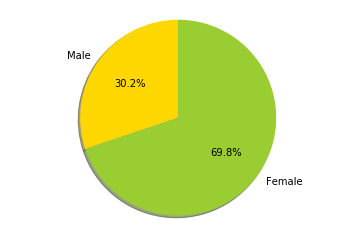

In [80]:
# Data to plot
labels = 'Male', 'Female'
sizes = [gender_pie['Raw_Text']['M'],gender_pie['Raw_Text']['F']]
colors = ['gold', 'yellowgreen']
explode = (0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.axis('equal')
plt.show()

In [ ]:
# grouped = df.groupby('BMI_level')
# BMIlevel_M = grouped.filter(lambda x: df['Gender'][x] =="M")
# # BMIlevel_F = grouped.filter(lambda x: df['Gender']=="F")

In [ ]:
#df.groupby(['col5','col2']).size().reset_index().groupby('col2')[[0]].max()


# gender_bmilevel_men = df[df['Gender']=="M"].groupby(['BMI_level','Gender']).count()
# gender_bmilevel_men['Raw_Text']

# men = df[df['Gender']=="M"]


In [ ]:
# labels = 'Underweight', 'Healthy','Overweight','Obese','Extremely_Obese'
# sizes = [gender_bmilevel_men['Raw_Text']]
# # colors = ['gold', 'yellowgreen']
# # explode = (0, 0, 0, 0)  # explode 1st slice

# # Plot
# plt.pie(sizes, 
#         labels=labels, 
# #         colors=colors,
#         autopct='%1.1f%%',
#         shadow=True, 
#         startangle=90)

# plt.axis('equal')
# plt.show()

### Bar Graph!

In [81]:
gender_bar = df.groupby('Gender').count()

In [82]:
gender_bar['Raw_Text']['F']

301

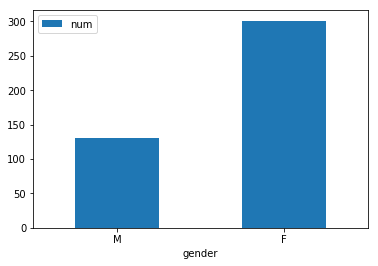

In [83]:
#https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
bar_num = pd.DataFrame({'gender':['M','F'], 'num':[ gender_bar['Raw_Text']['M'],gender_bar['Raw_Text']['F']]})
ax = bar_num.plot.bar(x='gender', y='num', rot=0)

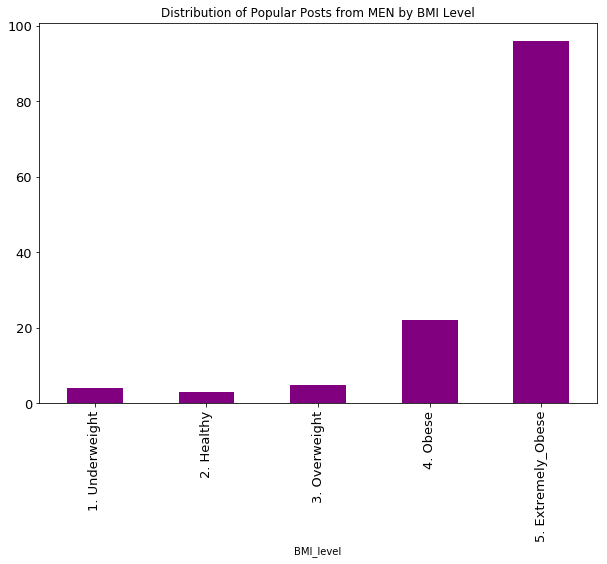

In [84]:
# 'M_BMI_Und' = 
# df[df['Gender']=="M",df['BMI_level']=="Underweight"].count()

# gender_bmilevel_men = df[df['Gender']=="M"].groupby(['BMI_level','Gender']).count()
# gender_bmilevel_men['Raw_Text']

# 'Healthy','Overweight','Obese','Extremely_Obese'



#https://stackoverflow.com/questions/61857569/making-a-barchart-in-pandas-with-filtered-data
df_men = df[df['Gender'] == 'M']

# men_BMI_bar = 
ax = df_men.groupby('BMI_level').agg('Raw_Text').count().plot(kind='bar', x='BMI_level', y='Raw_Text',figsize=(10,7),color="purple", fontsize=13, title='Distribution of Popular Posts from MEN by BMI Level')

# df_men.plot(kind='bar', x='BMI_level', y='Raw_Text')



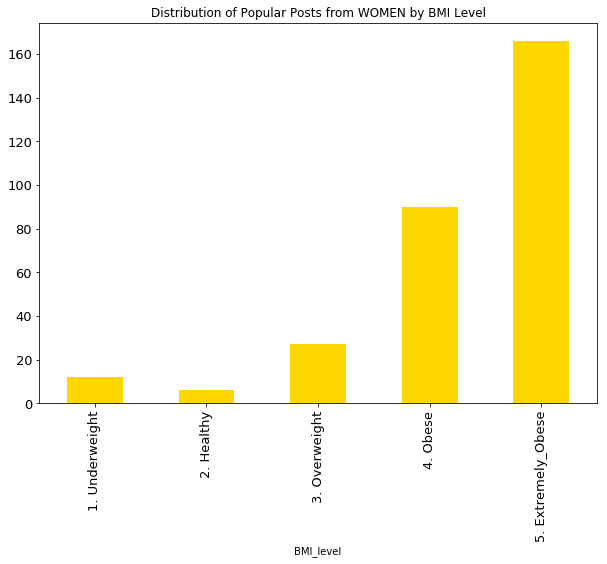

In [85]:
df_women = df[df['Gender'] == 'F']

df_women.groupby('BMI_level').agg('Raw_Text').count().plot(kind='bar', x='BMI_level', y='Raw_Text',figsize=(10,7),color="gold", fontsize=13, title='Distribution of Popular Posts from WOMEN by BMI Level')

In [ ]:
# #https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
# M_BMI_level = pd.DataFrame({'BMI Level':['Underweight', 'Healthy','Overweight','Obese','Extremely_Obese'], 
#                             'num':[ gender_bar['Raw_Text']['M'],
#                                    gender_bar['Raw_Text']['F']]})
# ax = M_BMI_level.plot.bar(x='gender', y='num', rot=0)

## Pair Plot

In [ ]:
# pd.plotting.scatter_matrix(
#     df_men.select_dtypes(include='number').iloc[:,-5:-1],
#     figsize=(12,12)
# );

In [86]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# colors = ["amber", "barney"]
# sns.pairplot(sns.xkcd_palette(colors))
# palette={'EMC': sns.xkcd_rgb["denim blue"],
#                                    'Random': sns.xkcd_rgb["pale red"]}

#https://xkcd.com/color/rgb/
#https://seaborn.pydata.org/tutorial/color_palettes.html
#https://www.programcreek.com/python/example/96199/seaborn.xkcd_rgb

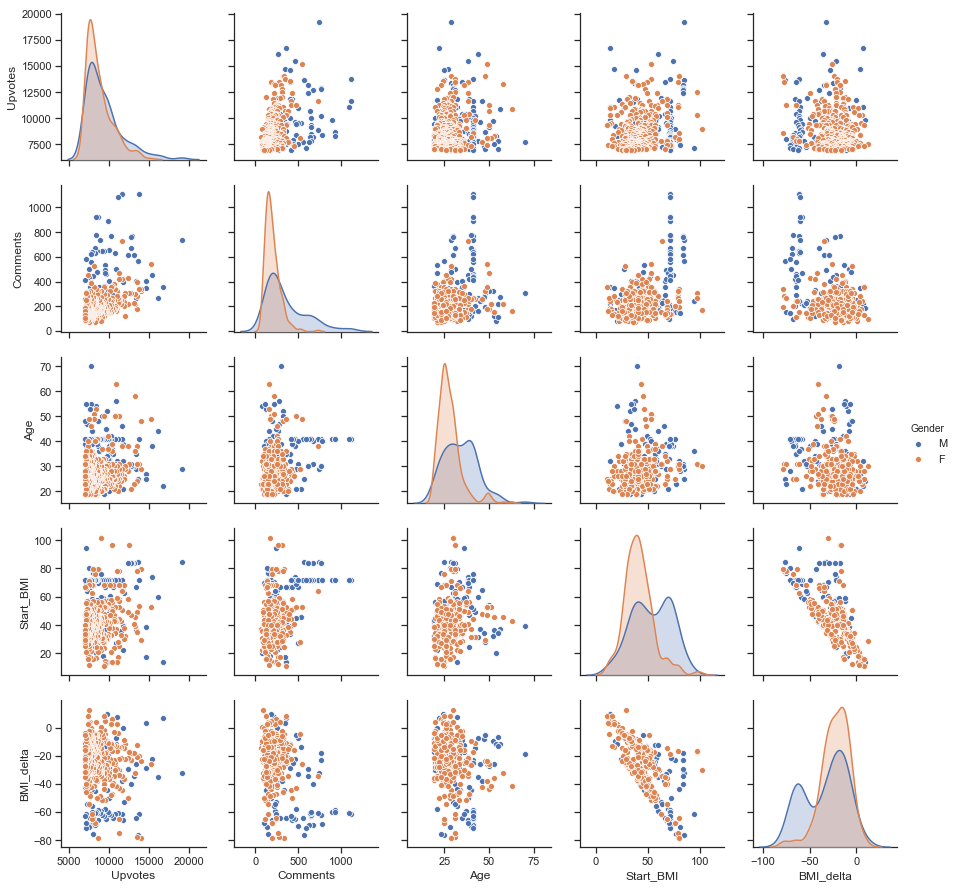

In [87]:
#https://seaborn.pydata.org/generated/seaborn.pairplot.html
g = sns.pairplot(df, hue="Gender", vars=["Upvotes", "Comments","Age","Start_BMI","BMI_delta"])

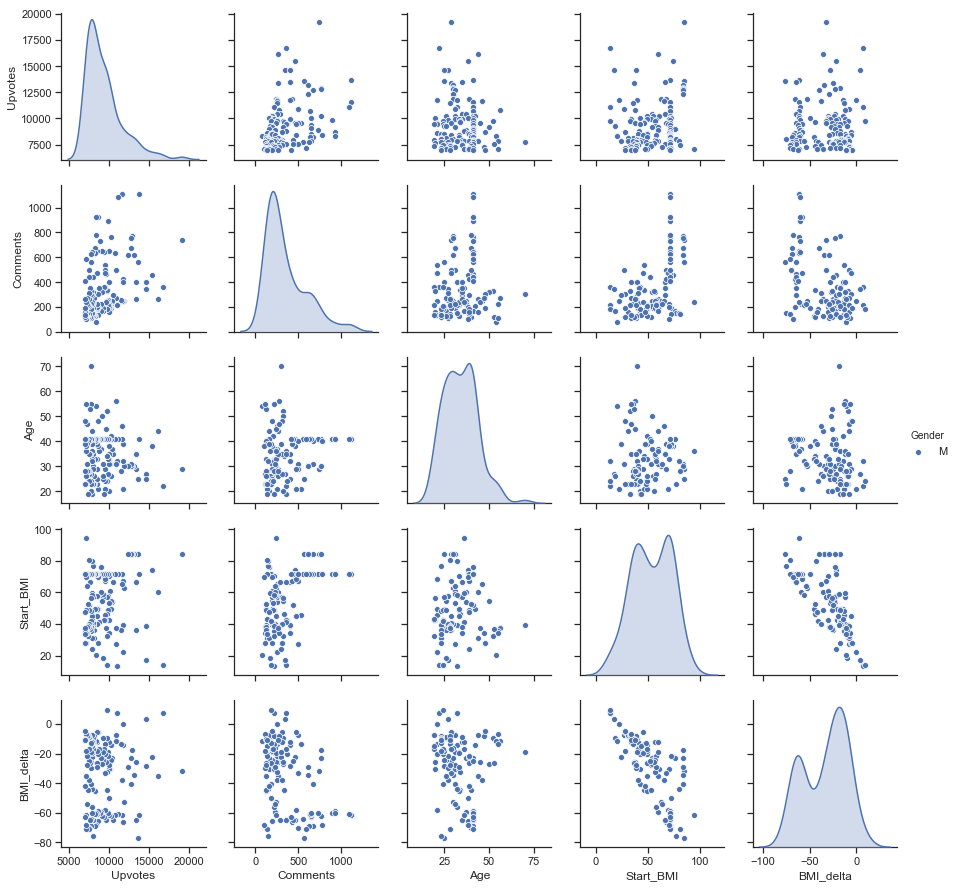

In [97]:
h = sns.pairplot(df_men, hue="Gender", vars=["Upvotes", "Comments","Age","Start_BMI","BMI_delta"])

In [ ]:
# Upvotes
# Comments
# Age
# Start_BMI
# BMI_delta

## Math!

### Age vs Upvotes

In [89]:
# seed random number generator
seed(1)
# calculate Pearson's correlation
corr, _ = pearsonr(df['Age'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)
#Result = Pearsons correlation: 0.109 (that means little correlation right?)

Pearsons correlation: 0.109


### BMI Delta vs Upvotes

In [90]:
# seed random number generator
seed(1)
# calculate Pearson's correlation
corr, _ = pearsonr(df['BMI_delta'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)
#Result = Pearsons correlation: -0.112 (that means little correlation right?)

Pearsons correlation: -0.112


In [95]:
#corr, _ = pearsonr(df_men, df['Upvotes'])

### Starting BMI vs Upvotes

In [91]:
# seed random number generator
seed(1)
# calculate Pearson's correlation
corr, _ = pearsonr(df['Start_BMI'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)
#Result = Pearsons correlation: 0.224 (that means little correlation right?)

Pearsons correlation: 0.224


### Comments vs Upvotes

In [92]:
# seed random number generator
seed(1)
# calculate Pearson's correlation
corr, _ = pearsonr(df['Comments'], df['Upvotes'])
print('Pearsons correlation: %.3f' % corr)
#Result = Pearsons correlation: 0.408 (that means pretty good correlation right?)

Pearsons correlation: 0.408


## Scatter plot!

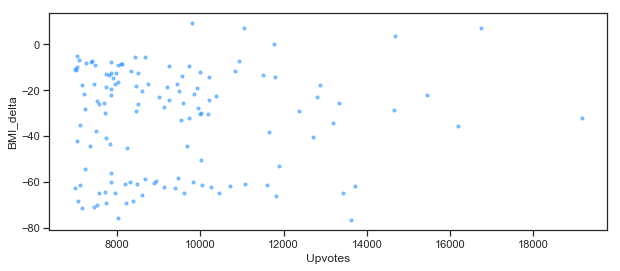

In [180]:



df_men.plot(kind='scatter', x='Upvotes', y='BMI_delta', \
        color='dodgerblue', figsize=(10,4), s=10, alpha=0.5)
#draw a trendline here: https://stackoverflow.com/questions/41635448/how-can-i-draw-scatter-trend-line-on-matplot-python-pandas/41635626

## Questions to Ask Carleton

1)Pearsons correlation: 0.109 (that means no correlation right?)
    True
    
2)What's the best way to better understand the math?
    lin alg / stats (consider working on concepts first before getting into nitty gritty)

3)Should presentation be pdf/ppt/slides or RISE format?
    Anything

4)How to interpret pairplots?
    Think of them as histogram (actually density plots) of the variable.

5)In the bar graphs, I want to show somethig like this: https://www.basic-mathematics.com/images/double-bar-graphs.gif that compares overall population vs top 50 population. How to show double bar graph?
    Look at seaborn. Grouped Bar Chart.

6)How to find correlation between gender and upvotes? (since gender is categorical)
    Need to encode the genders to be 1 or 0
    
Ultimate question I want to answer is: Is there a correlation between upvotes and BMI lost by gender? (Hypothesis: BMI magniture correlated with upvotes for men, not correlated for women)

I tried this: #corr, _ = pearsonr(df_men, df['Upvotes'])


add stuff about the story. this is what you set out to do. this is your hypo. analysis, interesting fnidings, recommendations. 


## Additional Questions!

1) It's possible that more women post their pictures than men. I would like to explore the full dataset to see if that's the case. 
2) Is there a correlation between number of OP comments and popularity? (Are users "rewards" for being present?)